In [ ]:
from __future__ import annotations
import math,numpy as np, matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate

import logging,pickle,gzip,os,time,shutil,torch,matplotlib as mpl
from pathlib import Path

from torch import tensor,nn,optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset,load_dataset_builder

import torchvision.transforms.functional as TF
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

mpl.rcParams['image.cmap'] = 'gray'

logging.disable(logging.WARNING)

In [ ]:
# Huggingface datasets will have typically dictionaries that will provide us all the .info which we can get
# features adn splits for our train and test
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

ds_builder.info.features
ds_builder.info.splits

dsd = load_dataset(name)
dsd

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [1]:
# After we have loaded the dataset we can get the train and test datasets
train,test = dsd['train'],dsd['test']
train[0]

NameError: name 'dsd' is not defined

In [2]:
# We can make our collate function to return a dictionary of our tensors
# We can also use training_dataset.with_transform(transforms) will run the transform like a generator whenever our dataset is loaded

# 

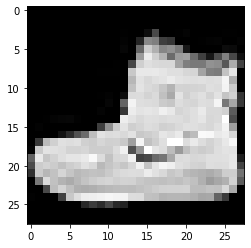

In [ ]:
b = next(iter(dl))
xb = b['image']
img = xb[0]
plt.imshow(img[0]);

In [ ]:
# Here we make sure that it is on the cpu as well as the dimensions being correctly ordered for how matplotlib should do
# It will remove the a xis to show teh image tooa nd make sure that the data is a np array

@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

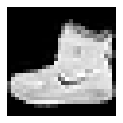

In [ ]:
show_image(img, figsize=(2,2))

In [ ]:
# Creates sub plots that are axes - these are just individual plots
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows: int = 1, # Number of rows in returned axes grid
    ncols: int = 1, # Number of columns in returned axes grid
    figsize: tuple = None, # Width, height in inches of the returned figure
    imsize: int = 3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle: str = None, # Title to be set to returned figure
    **kwargs
):
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: 
        figsize=(ncols*imsize, nrows*imsize)
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: 
        fig.suptitle(suptitle)
    if nrows * ncols == 1: 
        ax = np.array([ax])
    return fig, ax

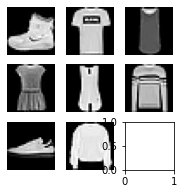

In [ ]:
fig,axs = subplots(3,3, imsize=1)
imgs = xb[:8]
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [ ]:
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

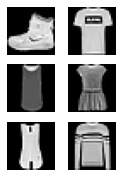

In [ ]:
fig,axs = get_grid(8, nrows=3, imsize=1)
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [ ]:
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [ ]:
yb = b['label']

lbls = yb[:8]
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()

titles = itemgetter(*lbls)(names)
' '.join(titles)

show_images(imgs, imsize=1.7, titles=titles)

In [ ]:
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))